In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2


# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
# from tensorflow.python.keras.layers import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

from predefined_functions import *

2024-05-21 15:49:39.260537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:49:43.793702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Walk through each directory
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
dataset = r"animals"
walk_through_dir(dataset)

There are 106 directories and 0 images in 'animals'.
There are 0 directories and 91 images in 'animals/raccoon'.
There are 0 directories and 90 images in 'animals/rat'.
There are 0 directories and 90 images in 'animals/reindeer'.
There are 0 directories and 90 images in 'animals/rhinoceros'.
There are 0 directories and 90 images in 'animals/seahorse'.
There are 0 directories and 88 images in 'animals/seal'.
There are 0 directories and 90 images in 'animals/shark'.
There are 0 directories and 90 images in 'animals/sheep'.
There are 0 directories and 90 images in 'animals/shrimp'.
There are 0 directories and 90 images in 'animals/snail'.
There are 0 directories and 89 images in 'animals/snake'.
There are 0 directories and 90 images in 'animals/squid'.
There are 0 directories and 87 images in 'animals/squirrel'.
There are 0 directories and 90 images in 'animals/starfish'.
There are 0 directories and 90 images in 'animals/swan'.
There are 0 directories and 90 images in 'animals/tiger'.
The

In [8]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [9]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

Label
bird           113
caterpillar    110
cattle         110
cat            110
elk            107
              ... 
mongoose        84
antelope        71
ape             66
bison           60
bee             29
Name: count, Length: 106, dtype: int64


/tmp/ipykernel_6244/3644734815.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/tmp/ipykernel_6244/3644734815.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


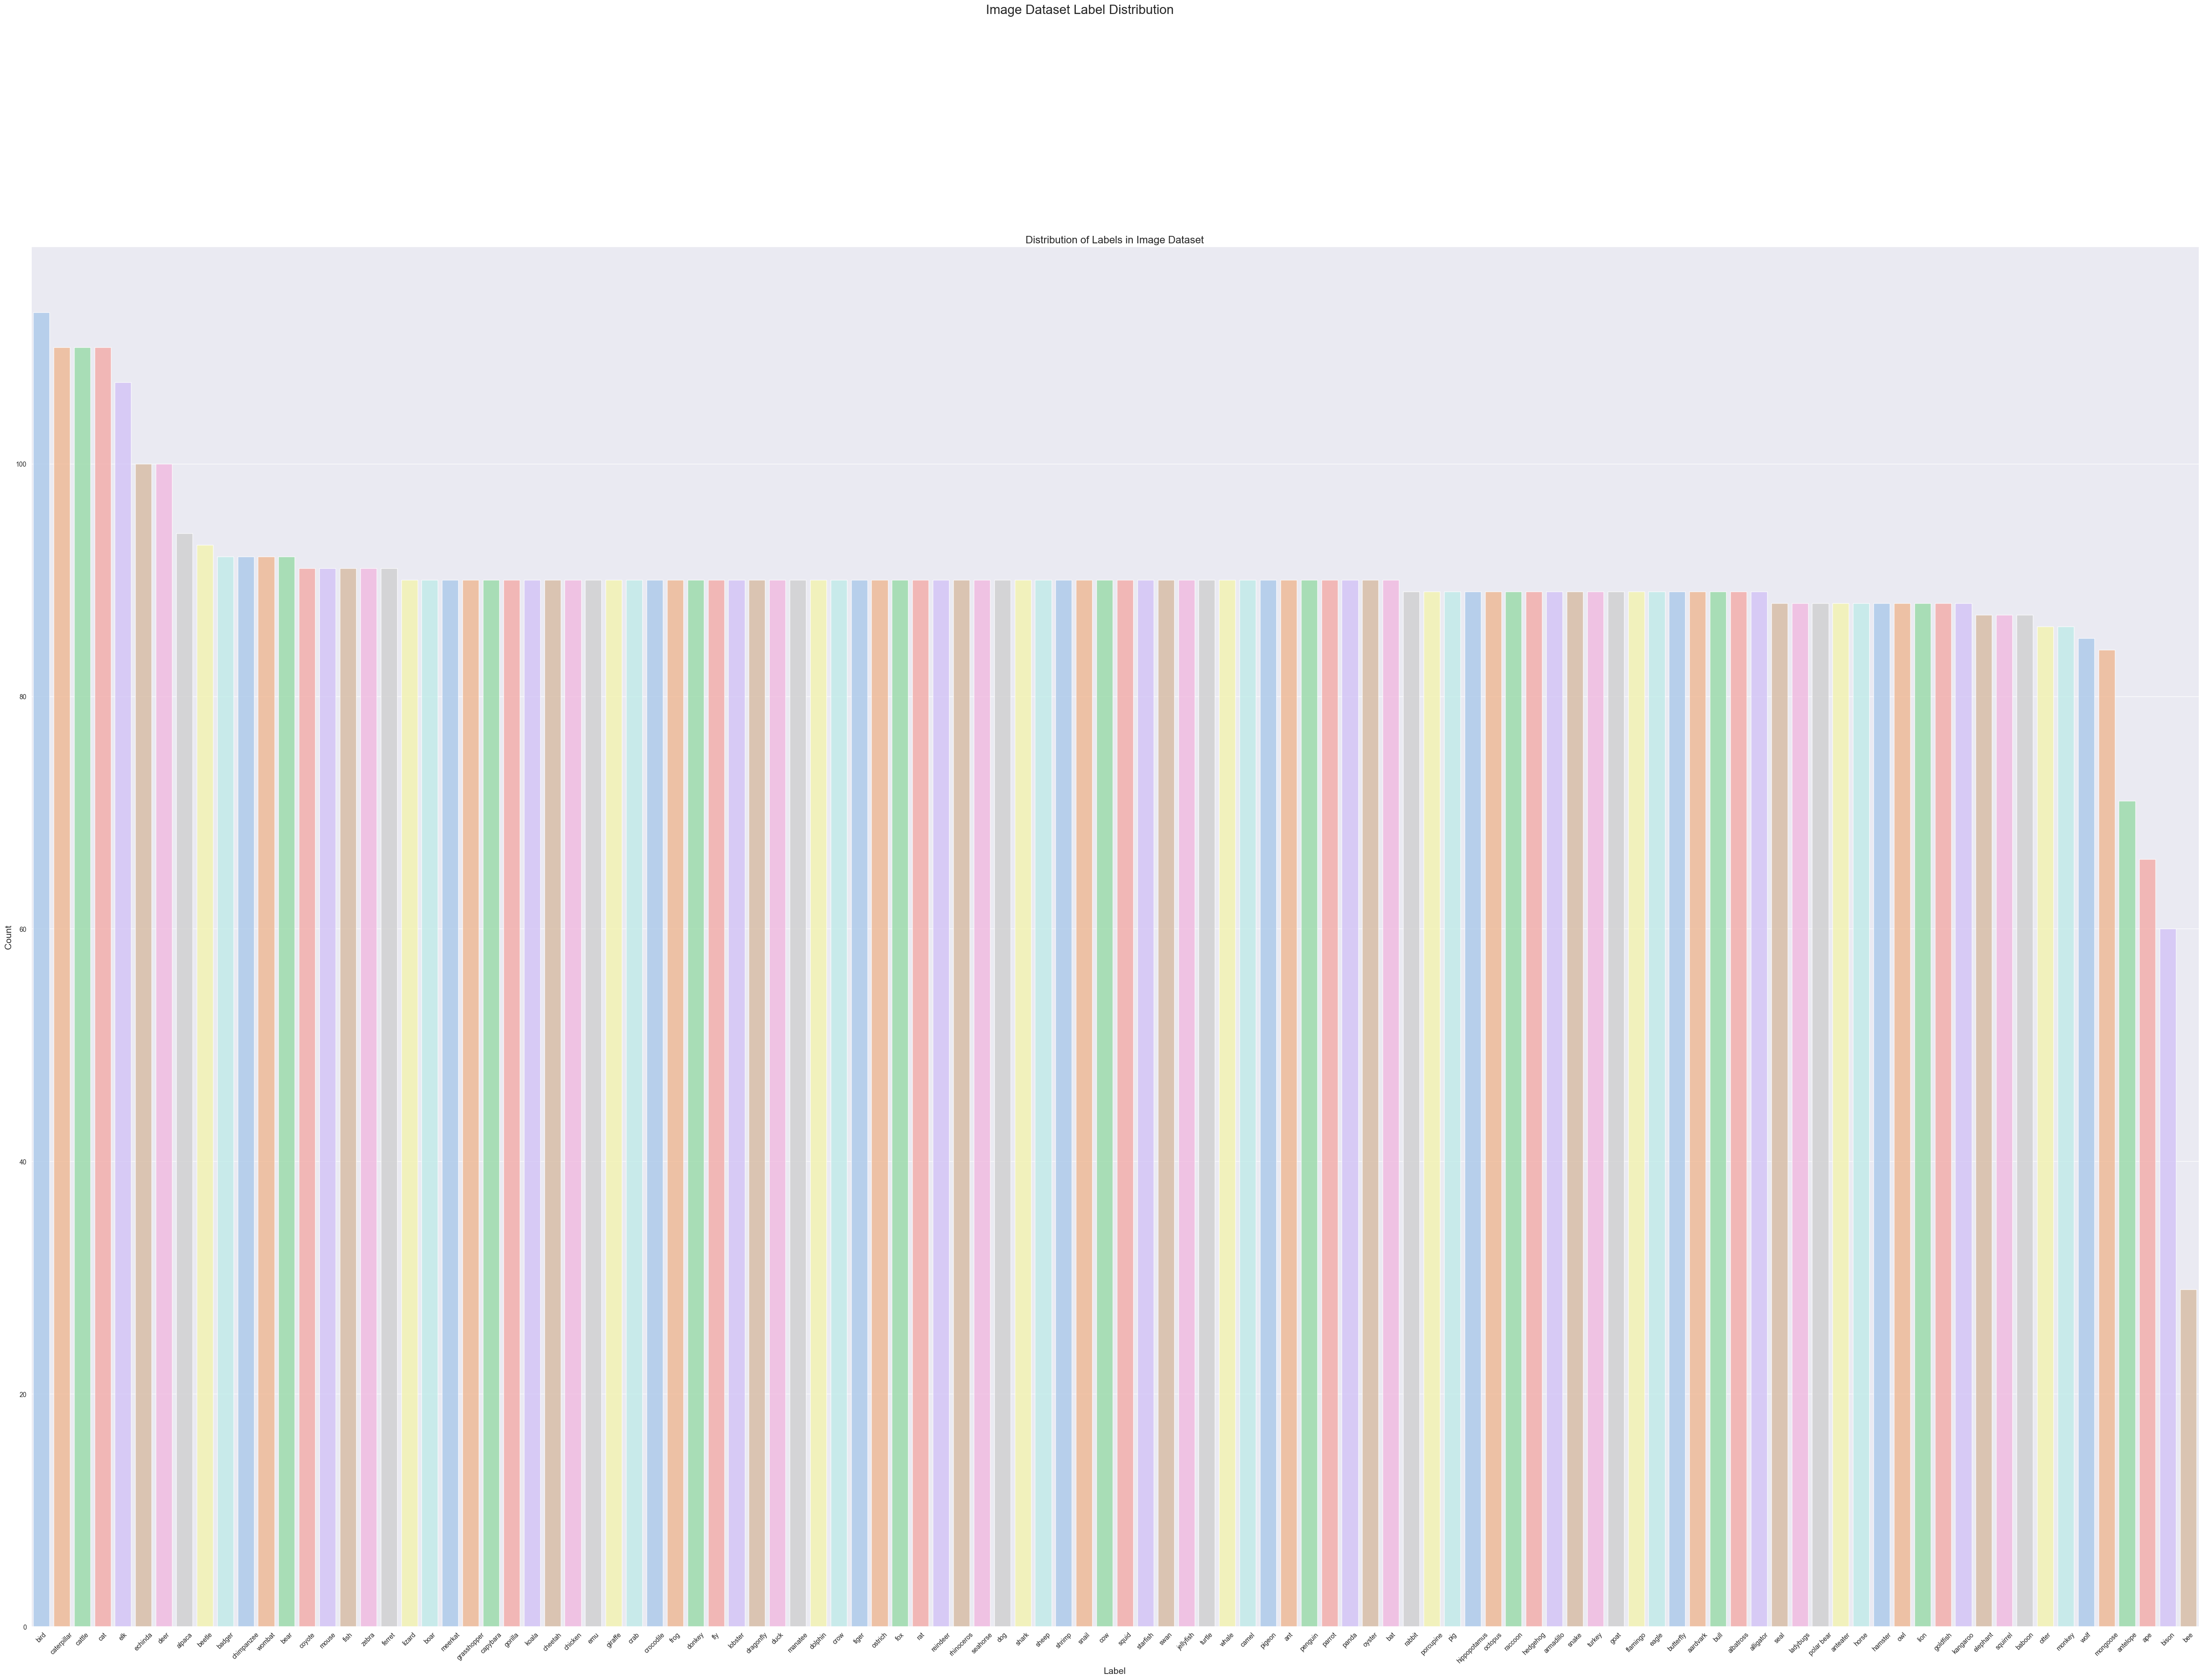

In [10]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()
print(label_counts)
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(60, 40))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

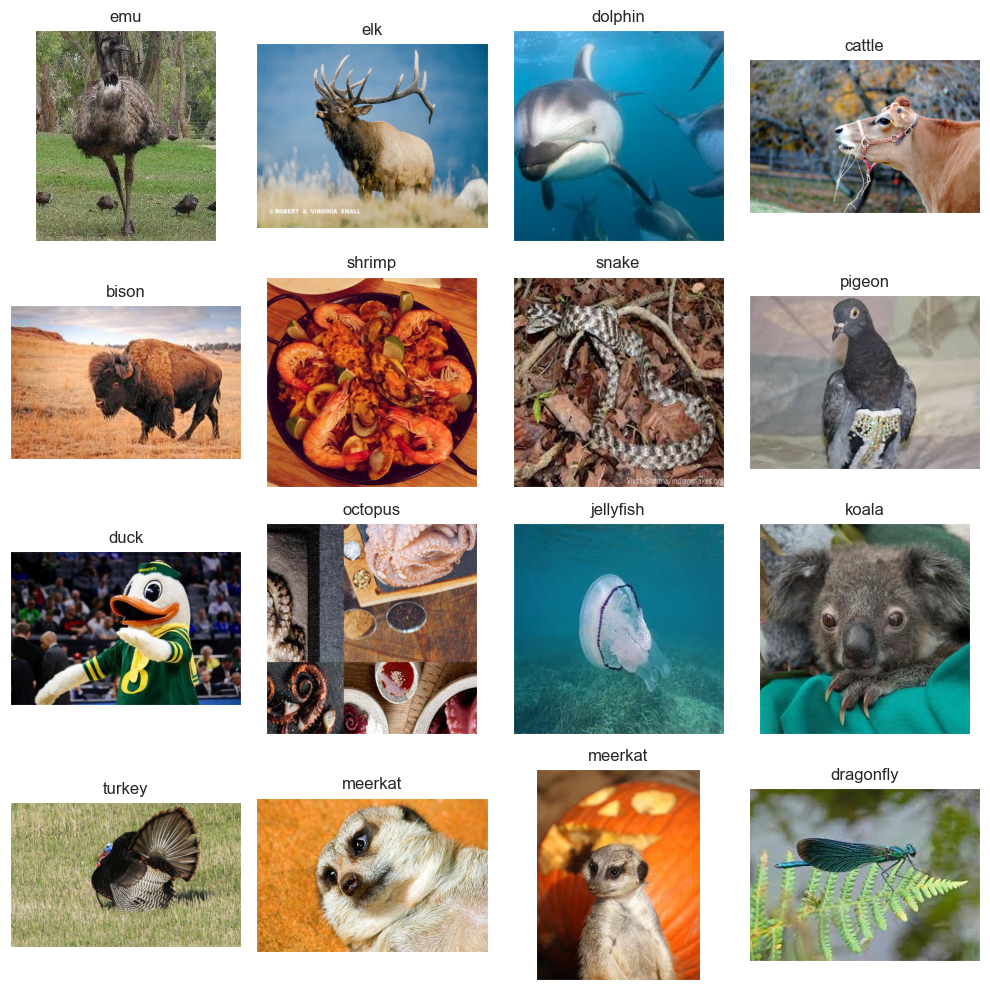

In [11]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

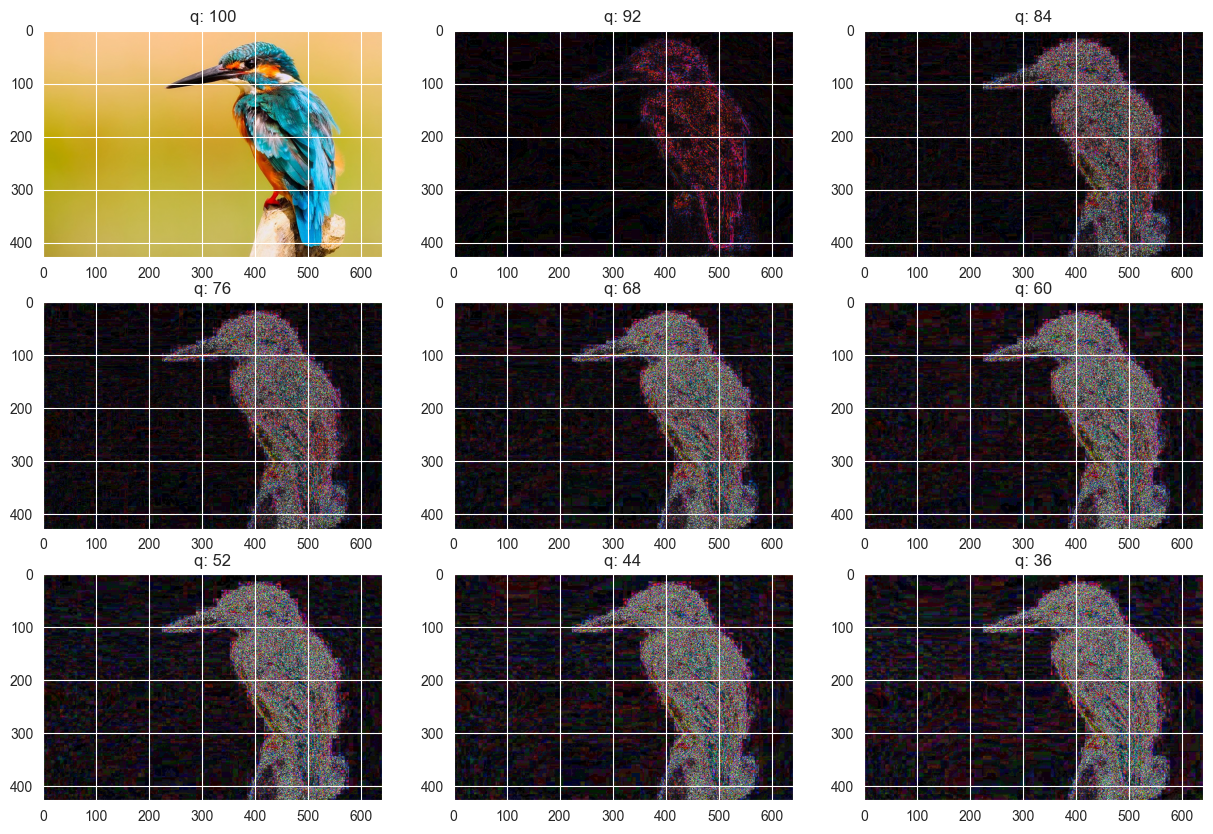

In [12]:
from PIL import Image, ImageChops, ImageEnhance

p = 'animals/bird/004_kingfisher-2046453_640.jpg'
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff



fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [15]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [16]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [17]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6068 validated image filenames belonging to 106 classes.
Found 1516 validated image filenames belonging to 106 classes.
Found 1896 validated image filenames belonging to 106 classes.


In [18]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])


2024-05-21 15:55:38.798502: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-05-21 15:55:38.798602: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: the-boss15725
2024-05-21 15:55:38.798609: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: the-boss15725
2024-05-21 15:55:38.798782: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.161.8
2024-05-21 15:55:38.798803: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 470.239.6
2024-05-21 15:55:38.798809: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 470.239.6 does not match DSO version 535.161.8 -- cannot find working devices in this configuration


In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258088960/258076736 [==============================] - 24s 0us/step


In [13]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [14]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(106, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        # create_tensorboard_callback("training_logs", 
        #                             "animals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/100
368/368 [==============================] - 220s 520ms/step - loss: 5.7630 - accuracy: 0.0112 - val_loss: 4.7241 - val_accuracy: 0.0197 - lr: 1.0000e-05
Epoch 2/100
368/368 [==============================] - 127s 344ms/step - loss: 5.4415 - accuracy: 0.0180 - val_loss: 4.4279 - val_accuracy: 0.0578 - lr: 1.0000e-05
Epoch 3/100
368/368 [==============================] - 126s 343ms/step - loss: 5.1537 - accuracy: 0.0295 - val_loss: 4.1227 - val_accuracy: 0.1155 - lr: 1.0000e-05
Epoch 4/100
368/368 [==============================] - 134s 365ms/step - loss: 4.8926 - accuracy: 0.0464 - val_loss: 3.8273 - val_accuracy: 0.2005 - lr: 1.0000e-05
Epoch 5/100
368/368 [==============================] - 127s 346ms/step - loss: 4.6459 - accuracy: 0.0650 - val_loss: 3.5903 - val_accuracy: 0.2871 - lr: 1.0000e-05
Epoch 6/100
368/368 [==============================] - 130s 353ms/step - loss: 4.4400 - accuracy: 0.0860 - val_loss: 3.3556 - val_accuracy: 0.3510 - lr: 1.0000e-05
Epoch 7/100
368/

Epoch 51/100
368/368 [==============================] - 126s 341ms/step - loss: 1.4738 - accuracy: 0.6601 - val_loss: 0.8681 - val_accuracy: 0.8016 - lr: 1.0000e-05
Epoch 52/100
368/368 [==============================] - 126s 343ms/step - loss: 1.4590 - accuracy: 0.6610 - val_loss: 0.8563 - val_accuracy: 0.8039 - lr: 1.0000e-05
Epoch 53/100
368/368 [==============================] - 127s 344ms/step - loss: 1.4153 - accuracy: 0.6690 - val_loss: 0.8482 - val_accuracy: 0.8043 - lr: 1.0000e-05
Epoch 54/100
368/368 [==============================] - 126s 343ms/step - loss: 1.3971 - accuracy: 0.6805 - val_loss: 0.8393 - val_accuracy: 0.8090 - lr: 1.0000e-05
Epoch 55/100
368/368 [==============================] - 126s 341ms/step - loss: 1.4050 - accuracy: 0.6681 - val_loss: 0.8270 - val_accuracy: 0.8084 - lr: 1.0000e-05
Epoch 56/100
368/368 [==============================] - 126s 344ms/step - loss: 1.3657 - accuracy: 0.6799 - val_loss: 0.8173 - val_accuracy: 0.8135 - lr: 1.0000e-05
Epoch 57/1

In [23]:
model.save('cnn_model.h5')

C:\Users\my pc\anaconda3\envs\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [15]:
results = model.evaluate(test_images, verbose=0)
print(results)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


[0.5241082310676575, 0.8605978488922119]
Test Loss: 0.52411
Test Accuracy: 86.06%


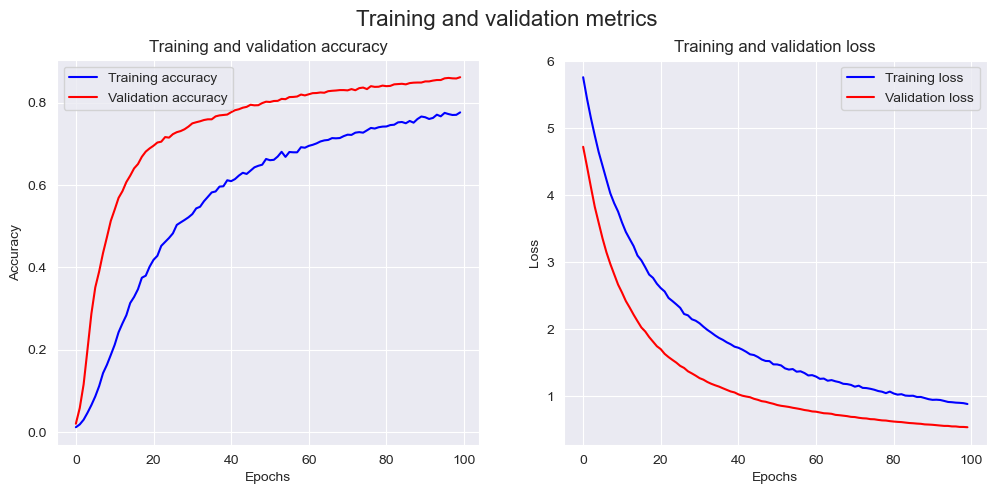

In [16]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()


In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['bat', 'lion', 'anteater', 'mongoose', 'capybara']


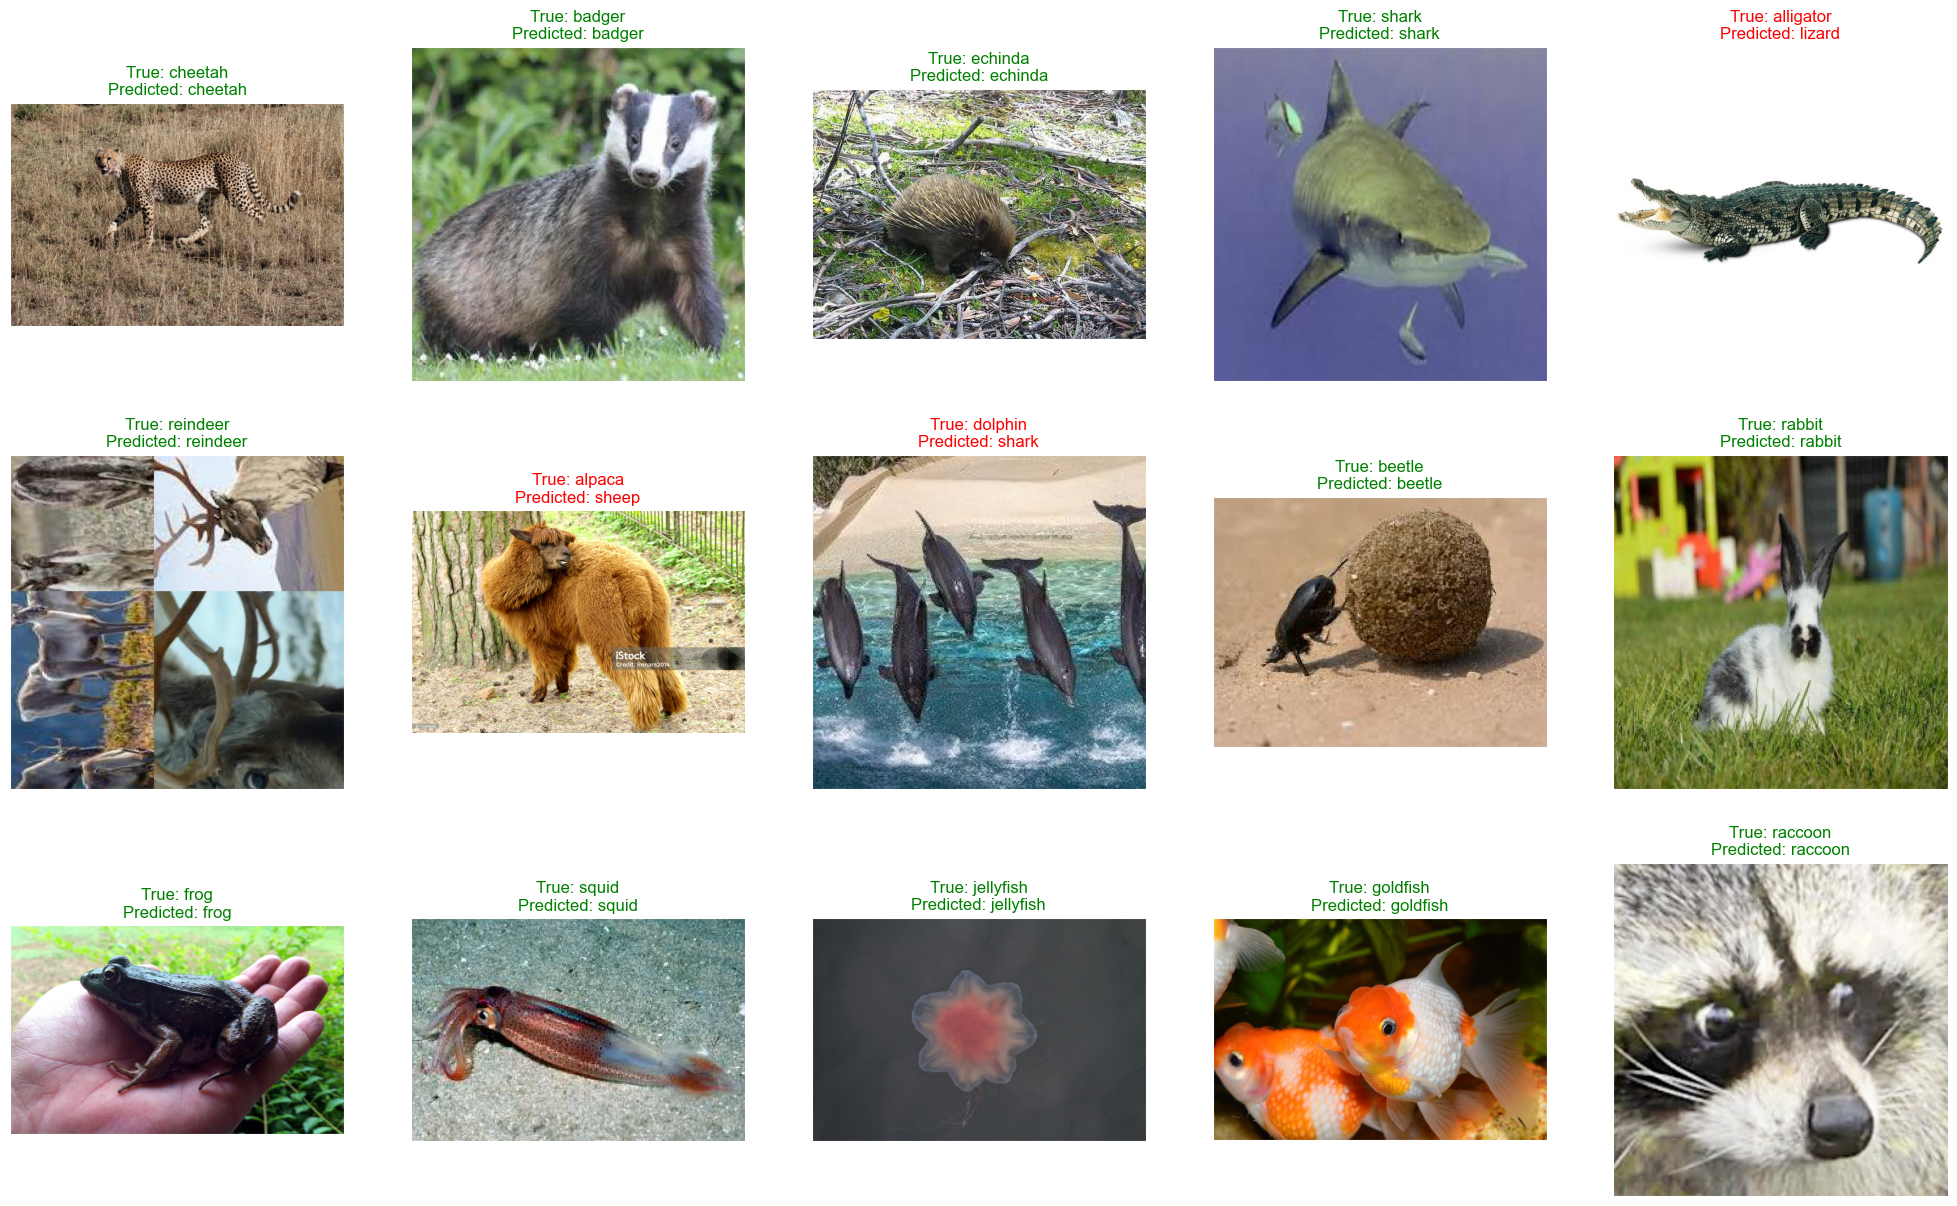

<Figure size 640x480 with 0 Axes>

In [18]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [19]:
y_test = list(test_df.Label)
cnn_report=(classification_report(y_test, pred))
print(cnn_report)

              precision    recall  f1-score   support

    aardvark       1.00      0.10      0.18        10
   albatross       0.97      0.95      0.96        38
   alligator       0.83      0.95      0.88        40
      alpaca       0.82      0.93      0.87        30
         ant       0.91      1.00      0.96        43
    anteater       0.79      0.89      0.84        35
    antelope       0.70      0.79      0.74        33
         ape       0.56      0.42      0.48        24
   armadillo       0.88      0.94      0.91        32
      baboon       0.87      0.94      0.91        36
      badger       1.00      0.89      0.94        28
         bat       0.57      0.90      0.69        29
        bear       0.96      1.00      0.98        47
         bee       0.96      0.93      0.95        28
      beetle       1.00      1.00      1.00        48
        bird       0.76      0.82      0.79        34
       bison       0.83      0.86      0.85        29
        boar       0.83    

C:\Users\my pc\anaconda3\envs\tf2.7\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head()

precision    recall  f1-score  support
aardvark    1.000000  0.100000  0.181818     10.0
albatross   0.972973  0.947368  0.960000     38.0
alligator   0.826087  0.950000  0.883721     40.0
alpaca      0.823529  0.933333  0.875000     30.0
ant         0.914894  1.000000  0.955556     43.0

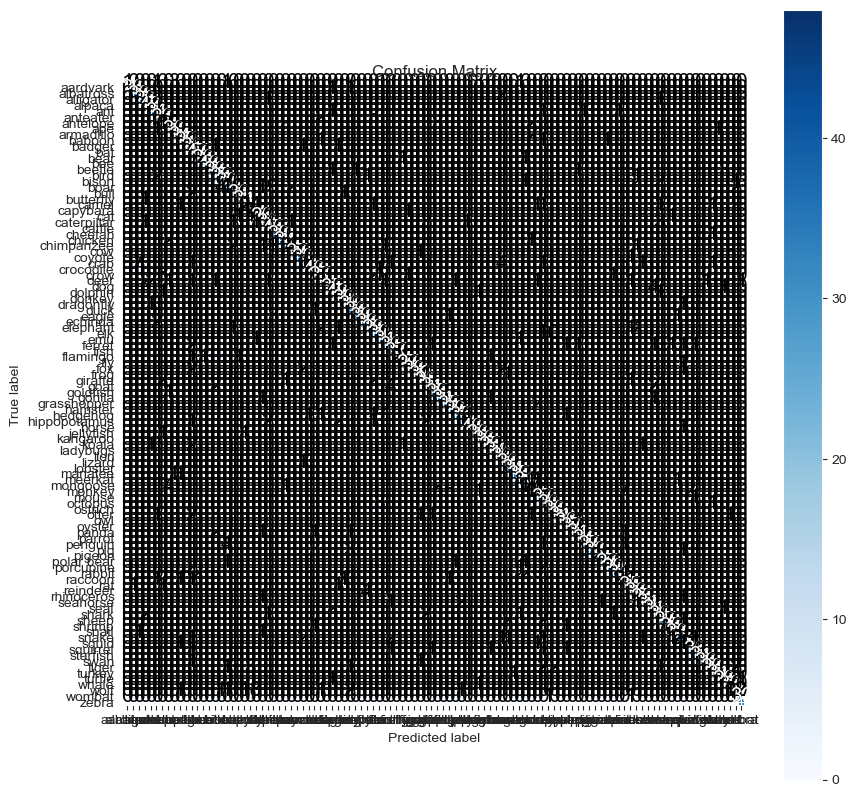

In [21]:
make_confusion_matrix(y_test, pred, list(labels.values()))
